In [34]:
import joblib
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GTFS import LINKED_TRIP_GROUPS, TIME_COLS
from matplotlib import dates
from datetime import datetime


REGRESSION_MODEL_PATH = "models/power_consumption_linear_regression.sav"
DESIGN_MATRIX_PATH = "datasets/design_matrix.csv"
WAYNE_TRIPS_PATH = "datasets/wayne_trips_to_PA.pkl"
TEMP_PATH = "datasets/Temperature.csv"
WAYNE_COLS = ["service_id", "block_id", "trip_id", "shape_dist_traveled", "duration", "time_waiting"]
BUS_BATTERY_CAPACITY = 364
MODEL = joblib.load(REGRESSION_MODEL_PATH)
RANDOM_STATE = 42
STATE = np.random.RandomState(RANDOM_STATE)


M = pd.read_csv(DESIGN_MATRIX_PATH)
wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / 3600)
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / row.duration_hours, axis=1)
X1 = pd.read_csv(TEMP_PATH)["Temperature"]
X2 = X1 ** 2
X3 = M["Speed"]


# Create bootstrap distribution
B, X3_stdev = wayne_trips.shape[0] * 500, np.std(X3)
bootstrap_wayne = wayne_trips.sample(n=B, replace=True, random_state=RANDOM_STATE)
bootstrap_wayne["temperature"] = STATE.choice(X1, B, replace=True)
bootstrap_wayne["temp_sq"] = bootstrap_wayne.temperature ** 2
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed.apply(lambda x: STATE.normal(loc=x, scale=X3_stdev))
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed
bootstrap_wayne["predicted_consumption_kW"] = model.predict(bootstrap_wayne.iloc[:, 8:])
bootstrap_wayne["predicted_consumption_kWh"] = bootstrap_wayne.predicted_consumption_kW * bootstrap_wayne.duration_hours

# Group by service_id, block_id, trip_id
trips_total_kWh = bootstrap_wayne.groupby(["trip_id", "service_id", "block_id"])["predicted_consumption_kWh"].quantile(q=0.99)
trips_total_kWh = trips_total_kWh.reset_index().rename({"predicted_consumption_kWh": "predicted_consumption_99th"}, axis="columns")
trips_total_kWh.head()

# Get sums by block ID, service ID
blocks_total_kWh = trips_total_kWh.groupby(["block_id", "service_id"])["predicted_consumption_99th"].sum().reset_index()
blocks_total_kWh["block_is_incomplete"] = (blocks_total_kWh.predicted_consumption_99th > BUS_BATTERY_CAPACITY).astype(int)
blocks_total_kWh["block_kWh_deficit"] = blocks_total_kWh.predicted_consumption_99th - BUS_BATTERY_CAPACITY
blocks_total_kWh.block_kWh_deficit = blocks_total_kWh.block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)

# Join block info back onto trip info
wayne_trips = wayne_trips.merge(blocks_total_kWh, on=["block_id", "service_id"])

#blocks_total_kWh.sort_values(by="block_kWh_deficit", ascending=False)
wayne_trips[wayne_trips.block_id == "191WY001"]

blocks_total_kWh.to_pickle("datasets/service_blocks_prediction_kWh.pkl")



<Axes: xlabel='predicted_consumption_kW', ylabel='Density'>

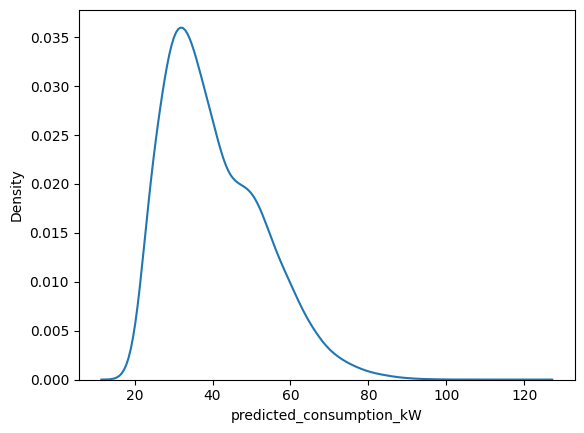

In [35]:
sns.kdeplot(bootstrap_wayne.predicted_consumption_kW, bw_adjust=3)
#sns.kdeplot(M["Power Consumption"])


<Axes: xlabel='predicted_consumption_kW', ylabel='Density'>

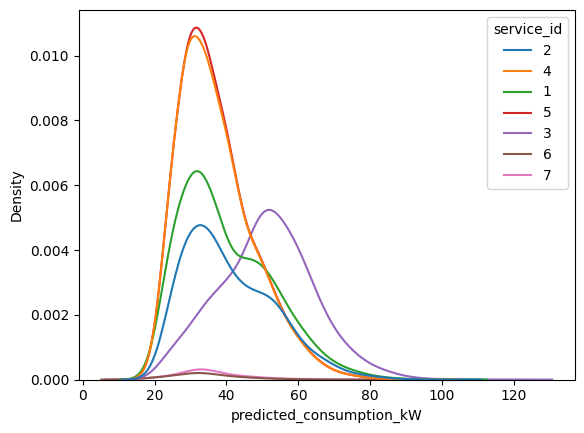

In [36]:
sns.kdeplot(data=bootstrap_wayne, x="predicted_consumption_kW", bw_adjust=3, hue=bootstrap_wayne.service_id.astype(str))


In [37]:
service_id_deficits = wayne_trips.groupby("service_id")[["block_kWh_deficit"]].sum().reset_index()
service_id_deficits["num_buses"] = np.ceil(service_id_deficits.block_kWh_deficit / BUS_BATTERY_CAPACITY)
service_id_deficits


,service_id,block_kWh_deficit,num_buses
0,1,7467.933489,21.0
1,2,8453.077131,24.0
2,3,944.469868,3.0
3,4,878.151975,3.0
4,5,879.350419,3.0
5,6,0.000000,0.0
6,7,0.000000,0.0


In [38]:
# Read in Wayne Trips (contains all trips to and from Wayne)
wayne_trips_to_PA = pd.read_pickle("datasets/wayne_trips_to_PA.pkl")

# Join on block_deficits
wayne_trips_to_PA = wayne_trips_to_PA.merge(blocks_total_kWh, on=LINKED_TRIP_GROUPS).drop("predicted_consumption_99th", axis=1)

# Join to get total kWh per trip
trip_deficits = wayne_trips_to_PA.merge(trips_total_kWh, on=["trip_id"] + LINKED_TRIP_GROUPS)
trip_deficits = trip_deficits[LINKED_TRIP_GROUPS + ["trip_id", "time_waiting", "is_port_authority_stop", "block_kWh_deficit", "first_arrival_time", "final_departure_time", "shape_dist_traveled", "predicted_consumption_99th"]]

# Add field to calculate the max charging per the schedule
trip_deficits["max_charging_kWh"] = trip_deficits.apply(lambda row: (row.time_waiting.total_seconds() / 3600) * (0.9*220) if row.is_port_authority_stop else 0, axis=1)

# Change the max charging to be the lower of predicted consumption and max_charging_kWh
trip_deficits["max_charging_kWh"] = trip_deficits.apply(lambda row: min(row.max_charging_kWh, row.predicted_consumption_99th), axis=1)

# Sort the data to ensure rolling sum is done in correct order
trip_deficits = trip_deficits.sort_values(by=LINKED_TRIP_GROUPS + ["final_departure_time", "first_arrival_time"])

# Group by service ID & block ID rolling sum of consumption and charging
rolling_stats = trip_deficits.groupby(LINKED_TRIP_GROUPS)[["predicted_consumption_99th", "max_charging_kWh"]].expanding(1).sum().reset_index(level=[0,1])

# Net consumption is consumption - charge
rolling_stats["net_consumption"] = rolling_stats.predicted_consumption_99th - rolling_stats.max_charging_kWh

# Net capacity is BUS_BATTER_CAPACITY - net_consumption
rolling_stats["net_capacity"] = BUS_BATTERY_CAPACITY - rolling_stats["net_consumption"]
trip_deficits["net_capacity"] = rolling_stats.net_capacity

# Show those block-service combinations that have negative net capacity
negative_net_capacity = rolling_stats[rolling_stats.net_capacity < 0][LINKED_TRIP_GROUPS].drop_duplicates()

# Join these service-blocks onto trip_deficits
trip_deficits = trip_deficits.merge(negative_net_capacity, on=LINKED_TRIP_GROUPS, how="left", indicator=True)

# Add indicator for whether or not service block has insufficient charge
trip_deficits["is_insufficient_charge"] = trip_deficits["_merge"].apply(lambda x: 1 if x == "both" else 0)

# Drop columns & rename
trip_deficits = trip_deficits.drop(["_merge", "time_waiting"], axis=1)
trip_deficits = trip_deficits.rename({"is_port_authority_stop": "is_PA_stop"}, axis=1)

# Only those trips whose service-block charge is insufficient
insufficient_service_blocks = trip_deficits[trip_deficits.is_insufficient_charge == 1].copy()


<Axes: xlabel='hour', ylabel='net_capacity'>

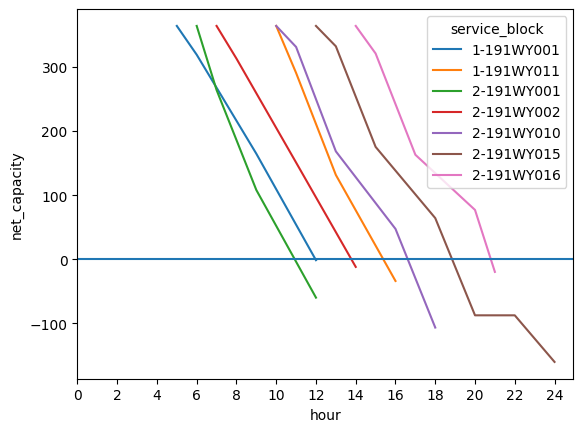

In [39]:
insufficient_service_blocks["service_block"] = insufficient_service_blocks.service_id.astype(str).str.cat(insufficient_service_blocks.block_id, sep="-")

# Convert the interval to a datetime from timedelta
insufficient_service_blocks["hour"] = insufficient_service_blocks.final_departure_time.apply(lambda x: x.total_seconds() // 3600)
insufficient_service_blocks["hour"]

# Some quick magic
y = insufficient_service_blocks.groupby("service_block")["hour"].min().to_dict()

new_entries = pd.concat([pd.DataFrame({"service_block": key, "hour": value - 1, "net_capacity": BUS_BATTERY_CAPACITY}, index=[str(key) + str(value)]) for key, value in y.items()])

insufficient_service_blocks = pd.concat([new_entries, insufficient_service_blocks])


graph = sns.lineplot(data=insufficient_service_blocks, x="hour", y="net_capacity", hue="service_block")
graph.axhline(0)

graph.set_xticks(range(0, 25, 2))
graph


In [10]:
wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / (60*60))
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / (row.duration_hours), axis=1)

# Do prediction given temp of 7.7 degrees F
wayne_trips["temp_1th_pred_kW"] = wayne_trips.apply(lambda x: x.avg_speed*1.55 - 1.48*7.7 + 0.0105*7.7**2, axis=1)
wayne_trips["temp_1th_pred_kWh"] = wayne_trips.duration_hours * wayne_trips.temp_1th_pred_kW

# Get sums by block ID
blocks_total_kWh = wayne_trips.groupby("block_id")["temp_1th_pred_kWh"].sum().reset_index()
blocks_total_kWh["block_is_incomplete"] = (blocks_total_kWh.temp_1th_pred_kWh > BUS_BATTERY_CAPACITY).astype(int)
blocks_total_kWh["block_kWh_deficit"] = blocks_total_kWh.temp_1th_pred_kWh - BUS_BATTERY_CAPACITY
blocks_total_kWh.block_kWh_deficit = blocks_total_kWh.block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)

# Join block info back onto trip info
wayne_trips = wayne_trips.merge(blocks_total_kWh, on="block_id")

# Get the num of buses needed
service_id_deficits = wayne_trips.groupby("service_id")[["block_is_incomplete", "block_kWh_deficit"]].sum().reset_index()
service_id_deficits["num_buses"] = np.ceil(service_id_deficits.block_kWh_deficit / BUS_BATTERY_CAPACITY)


In [11]:
missing_capacity = abs(int(insufficient_service_blocks.groupby(LINKED_TRIP_GROUPS)["net_capacity"].nth([-1]).sum()))
buses_required = int(np.ceil(abs(missing_capacity) / BUS_BATTERY_CAPACITY))
print(f"The number of buses required is {buses_required} for a capacity deficit of {missing_capacity} kWh")


The number of buses required is 2 for a capacity deficit of 392 kWh


In [13]:
num_trips = wayne_trips.trip_id.nunique()
num_blocks = wayne_trips.block_id.nunique()
num_services = wayne_trips.service_id.nunique()
num_service_blocks = wayne_trips[LINKED_TRIP_GROUPS].drop_duplicates().shape[0]

print(f"There are {num_trips} trips across {num_blocks} blocks and {num_services} service days. There are {num_service_blocks} total service blocks.")

There are 2265 trips across 358 blocks and 7 service days. There are 896 total service blocks.


In [17]:
wayne_trips_to_PA["is_port_authority_stop"].sum()

1153

In [26]:
service_block_consumption = trip_deficits.groupby(LINKED_TRIP_GROUPS)["predicted_consumption_99th"].sum().reset_index()

,block_id,service_id,predicted_consumption_99th
0,160WY001,1,408.562892
1,160WY001,2,125.885050
2,160WY001,4,118.000411
3,160WY001,5,116.807969
4,160WY002,1,349.057157
...,...,...,...
891,194WY038,3,182.378718
892,194WY039,3,237.780332
893,194WY040,3,351.078289
894,194WY041,3,96.426059


In [30]:
blocks_total_kWh.groupby("service_id").agg({"block_is_incomplete": ["sum", "count", "mean"]})


block_is_incomplete                
                           sum count      mean
service_id                                    
1                           41    99  0.414141
2                           33    72  0.458333
3                            7   222  0.031532
4                            7   248  0.028226
5                            7   249  0.028112
6                            0     2  0.000000
7                            0     4  0.000000

In [31]:
trip_deficits.head()

,block_id,service_id,trip_id,is_PA_stop,block_kWh_deficit,first_arrival_time,final_departure_time,shape_dist_traveled,predicted_consumption_99th,max_charging_kWh,net_capacity,is_insufficient_charge
0,160WY001,1,7914,1,44.562892,0 days 06:20:00,0 days 07:23:00,21.8258,66.429714,66.429714,364.000000,0
1,160WY001,1,7930,0,44.562892,0 days 07:50:00,0 days 08:52:00,22.2051,63.534061,0.000000,300.465939,0
2,160WY001,1,7917,1,44.562892,0 days 09:35:00,0 days 10:54:00,21.8258,69.559705,69.300000,300.206234,0
3,160WY001,1,7933,0,44.562892,0 days 11:15:00,0 days 12:23:00,22.2051,69.986588,0.000000,230.219646,0
4,160WY001,1,7920,1,44.562892,0 days 12:50:00,0 days 14:09:00,21.8258,70.869476,69.300000,228.650170,0
